# Estimating expressibility of different connectivity topologies

In this notebook we're going to use the expressibility estimator built for one qubit in another project to generalize to the n-qubits case with different circuit connectivity topologies. The number of parameters will be the same for every circuit, because we're going to change only the connection between qubits. First, we redefine the circuit fidelities function to have a generalized histogram, then define the circuits and finally compare with the Haar case.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr

#np.random.seed(42)

In [2]:
wires = 4 #number of qubits
dev = qml.device("default.qubit", wires=wires, shots=None)
dev1 = qml.device("default.qubit", wires=wires, shots=None)
dev2 = qml.device("default.qubit", wires=wires, shots=None)

# Fidelities for a definite number of samples

In this section we define the function that obtain the circuit histogram. The Haar case and the parameters definition are going to be done in another section after we define the circuits, to guarantee the consistency of both histograms.

## Circuit fidelity:

In [3]:
def fidel_histogram(binsnumb, samples, circuit):
    fidel_vector = []
    for i in range(samples):
        #angles1 = np.array([np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
        #             requires_grad=True)
        #angles2 = np.array([np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
        #             requires_grad=True)
        
        angles1 = np.array([[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)], 
                            [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]], requires_grad=True)
        
        
        angles2 = np.array([[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)], 
                            [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]], requires_grad=True)
        
        state1 = circuit(angles1)
        state2 = circuit(angles2)
        
        F = np.abs( np.dot(state1, state2) )**2
        
        fidel_vector.append(F)
        
    fidel_vector = np.asarray(fidel_vector)
    
    binsize = 1.0/binsnumb
    bins = np.arange(0, 1. + binsize, binsize)
    
    histogram, bins = np.histogram(fidel_vector, bins=bins)[0]/samples, np.histogram(fidel_vector, bins=bins)[1]
    
    return histogram, bins

# Circuits definition

## Identity circuit refference

In [4]:
def identity(rots):
    for i in range(wires):
        qml.Identity(wires = [i])
    return qml.state()

identity_circuit = qml.QNode(identity, dev)

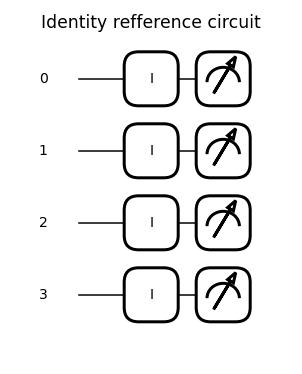

In [5]:
angles = np.array([[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
             [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]], requires_grad=True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(identity_circuit, decimals=2)(angles)
fig1.suptitle("Identity refference circuit", fontsize='xx-large')
plt.show()

## No connection circuit

In [6]:
def noconnec(rots):
    for i in range(wires):
        qml.RX(rots[0][i], wires=[i])
        qml.RY(rots[1][i], wires=[i])
    return qml.state()

noconnec_circuit = qml.QNode(noconnec, dev)

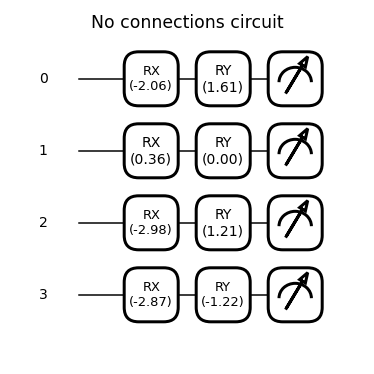

In [7]:
angles = np.array([[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
             [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]], requires_grad=True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(noconnec_circuit, decimals=2)(angles)
fig1.suptitle("No connections circuit", fontsize='xx-large')
plt.show()

## Linear connections

In [8]:
def linear(rots):
    for i in range(wires):
        qml.RX(rots[0][i], wires=[i])
        qml.RY(rots[1][i], wires=[i])
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.state()

linear_circuit = qml.QNode(linear, dev1)

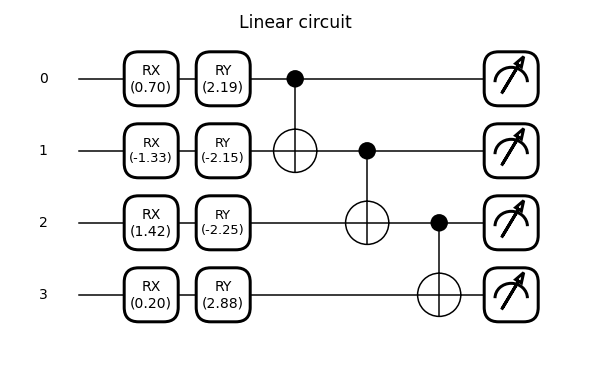

In [9]:
angles = np.array([[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
             [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]], requires_grad=True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(linear_circuit, decimals=2)(angles)
fig1.suptitle("Linear circuit", fontsize='xx-large')
plt.show()

## Ring connections ('oriented')

In [10]:
def ring(rots):
    for i in range(wires):
        qml.RX(rots[0][i], wires=[i])
        qml.RY(rots[1][i], wires=[i])
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    qml.CNOT(wires=[wires-1,0])
    return qml.state()

ring_circuit = qml.QNode(ring, dev2)

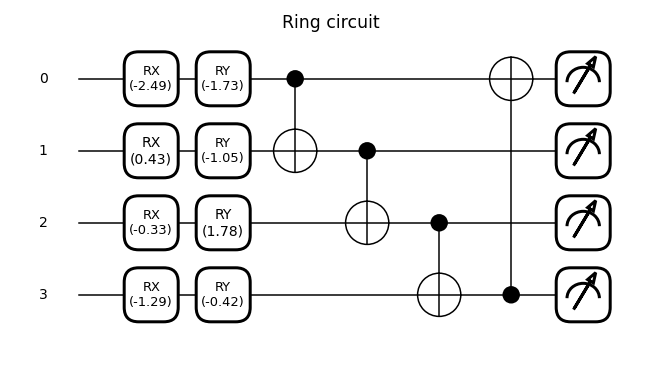

In [11]:
angles = np.array([[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
             [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]], requires_grad=True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(ring_circuit, decimals=2)(angles)
fig1.suptitle("Ring circuit", fontsize='xx-large')
plt.show()

## Star connections

In [12]:
def star(rots):
    for i in range(wires):
        qml.RX(rots[0][i], wires=[i])
        qml.RY(rots[1][i], wires=[i])
    for i in range(wires-1):
        qml.CNOT(wires = [0, i+1])
    return qml.state()

star_circuit = qml.QNode(star, dev)

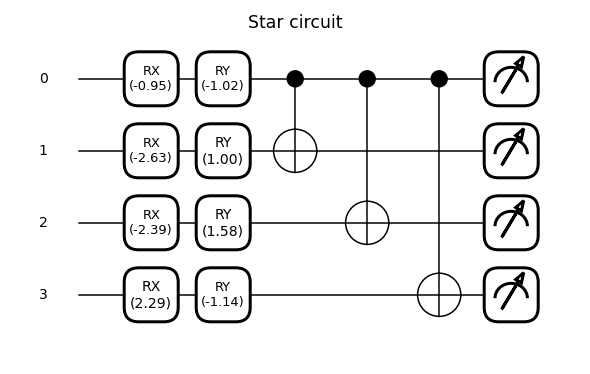

In [13]:
angles = np.array([[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
             [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]], requires_grad=True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(star_circuit, decimals=2)(angles)
fig1.suptitle("Star circuit", fontsize='xx-large')
plt.show()

## All-to-all connections

In [14]:
def alltoall(rots):
    for i in range(wires):
        qml.RX(rots[0][i], wires=[i])
        qml.RY(rots[1][i], wires=[i])
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="all_to_all")
    return qml.state()

alltoall_circuit = qml.QNode(alltoall, dev)

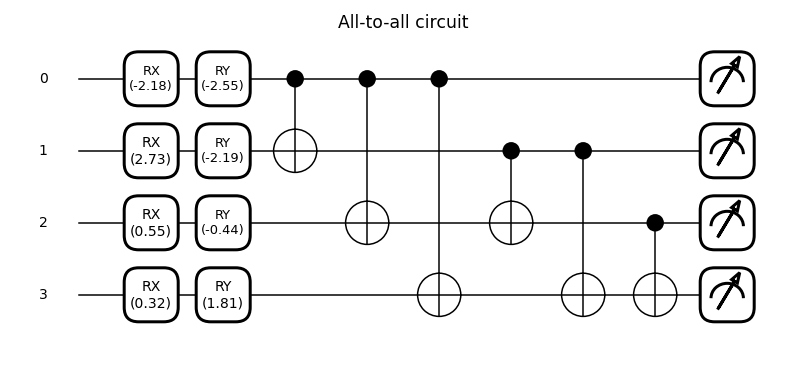

In [15]:
angles = np.array([[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
             [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]], requires_grad=True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(alltoall_circuit, decimals=2)(angles)
fig1.suptitle("All-to-all circuit", fontsize='xx-large')
plt.show()

# Haar distributed and circuits distributed histograms

In this section we define the parameters that are going to be used: sample size and number of bins (subdivisions of intervals in the histogram). The width parameter is only used to plot the graphs.

After that, we build the circuits and Haar histograms and compare them using the relative entropy. The values are going to be ploted together in a single graph using only one layer of each circuit.

## Parameters

In [16]:
samplesize = 10000
nbins = 75
width = 1.0/nbins

## Identity circuit refference

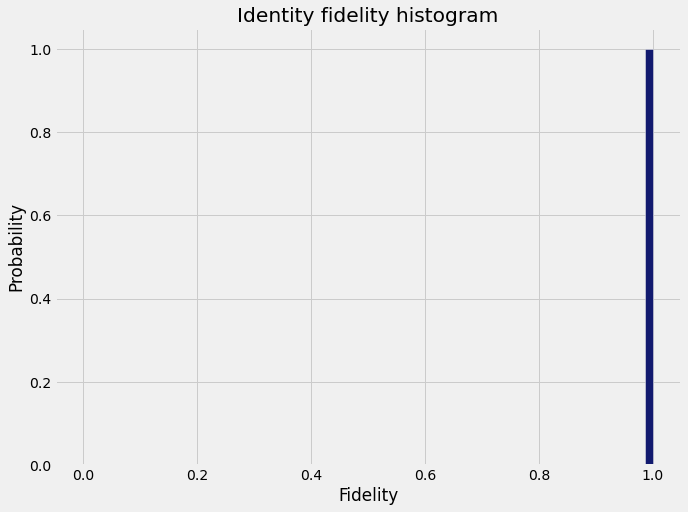

In [17]:
identity_hist, bins = fidel_histogram(nbins, samplesize, identity_circuit)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, identity_hist, color = '#121A6F', width = width)

ax.title.set_text('Identity fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## No connection

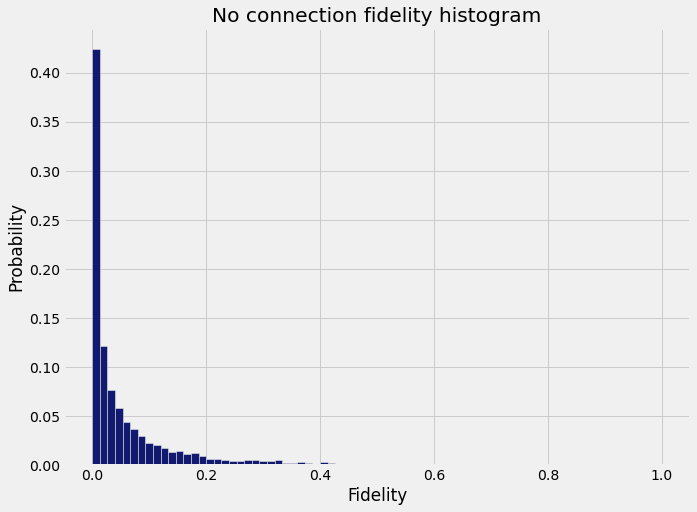

In [18]:
noconnec_hist, bins = fidel_histogram(nbins, samplesize, noconnec_circuit)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, noconnec_hist, color = '#121A6F', width = width)

ax.title.set_text('No connection fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## Linear

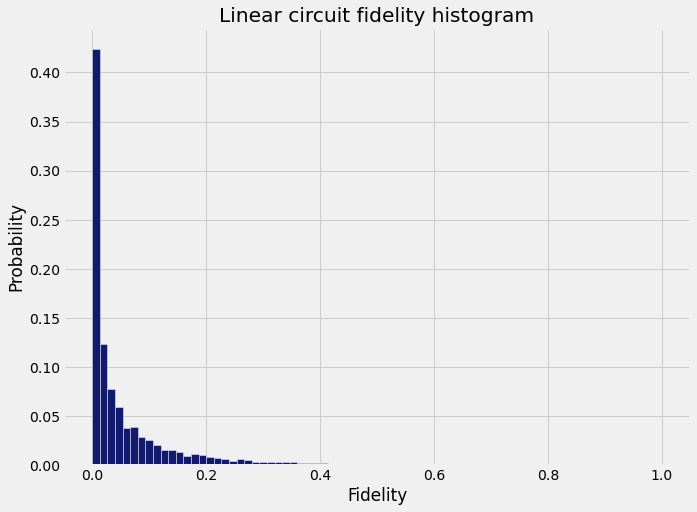

In [19]:
linear_hist, bins = fidel_histogram(nbins, samplesize, linear_circuit)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, linear_hist, color = '#121A6F', width = width)

ax.title.set_text('Linear circuit fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## Ring ('oriented')

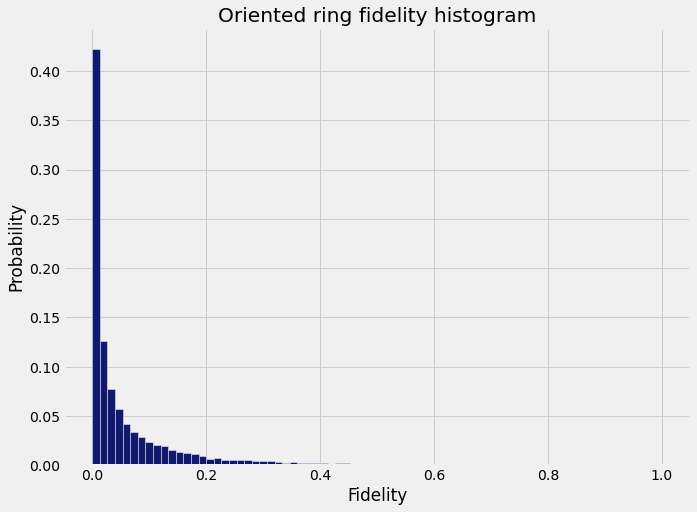

In [20]:
ring_hist, bins = fidel_histogram(nbins, samplesize, ring_circuit)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, ring_hist, color = '#121A6F', width = width)

ax.title.set_text('Oriented ring fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## Star

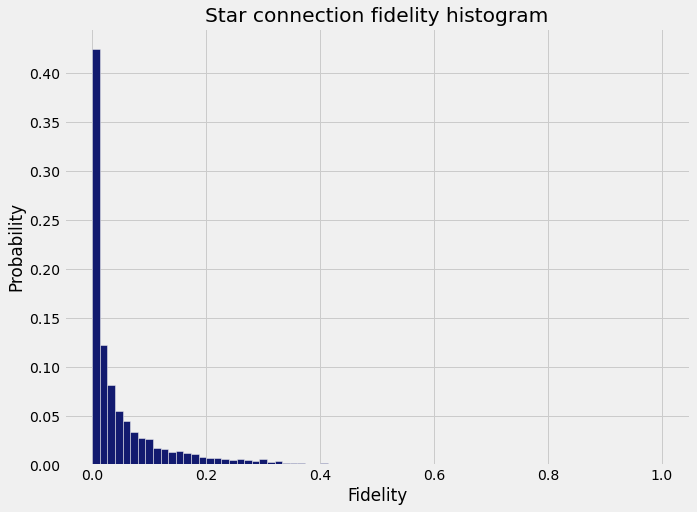

In [21]:
star_hist, bins = fidel_histogram(nbins, samplesize, star_circuit)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, star_hist, color = '#121A6F', width = width)

ax.title.set_text('Star connection fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## All-to-all

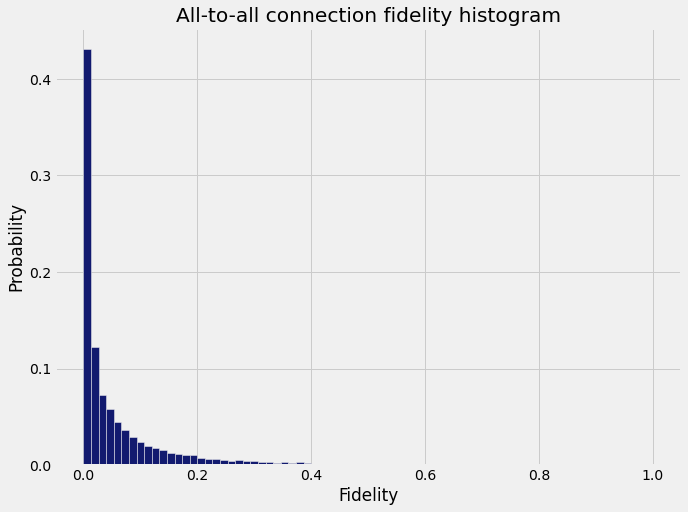

In [22]:
alltoall_hist, bins = fidel_histogram(nbins, samplesize, alltoall_circuit)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, alltoall_hist, color = '#121A6F', width = width)

ax.title.set_text('All-to-all connection fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## Haar

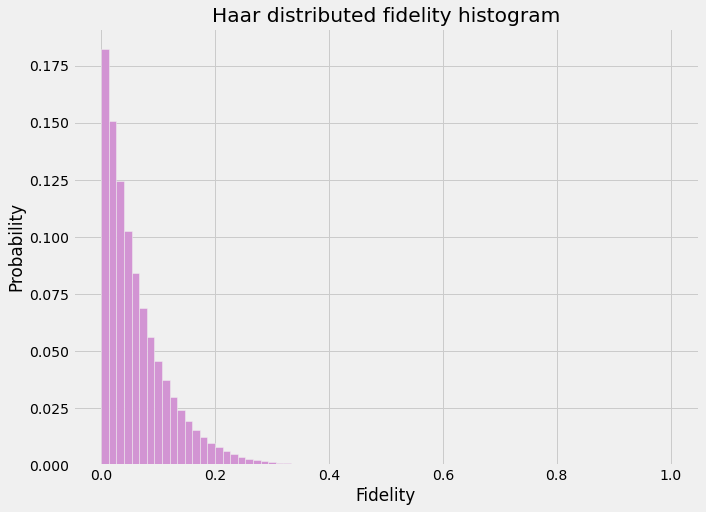

In [23]:
N = 2**wires #dimension of the Hilbert space

histogram_Haar = []

for i in range(nbins):
    histogram_Haar.append(  (1-bins[i])**(N-1) - (1-bins[i+1])**(N-1)  )
    
fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1] + width/2, histogram_Haar, color = '#D294D3', width = width)

ax.title.set_text('Haar distributed fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

# Expressibility values

## Identity refference

In [24]:
D_KL_identity = sum( rel_entr(identity_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.3f nats' % D_KL_identity)

Relative entropy S(Empir||Haar) = 64.762 nats


## No connection

In [31]:
D_KL_noconnec = sum( rel_entr(noconnec_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.4f nats' % D_KL_noconnec)

Relative entropy S(Empir||Haar) = 0.3067 nats


## Linear

In [32]:
D_KL_linear = sum( rel_entr(linear_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.4f nats' % D_KL_linear)

Relative entropy S(Empir||Haar) = 0.2934 nats


## Ring ('oriented')

In [33]:
D_KL_ring = sum( rel_entr(ring_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.4f nats' % D_KL_ring)

Relative entropy S(Empir||Haar) = 0.3024 nats


## Star

In [34]:
D_KL_star = sum( rel_entr(star_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.4f nats' % D_KL_star)

Relative entropy S(Empir||Haar) = 0.2909 nats


## All-to-all

In [35]:
D_KL_alltoall = sum( rel_entr(alltoall_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.4f nats' % D_KL_alltoall)

Relative entropy S(Empir||Haar) = 0.2950 nats


# Verificar problemas:

Possibilidade 2: de fato só alterar as conexões não altera a expressibilidade. Se isso for verdade, vou calcular as capacidades de emaranhamento dos circuitos e isso fica como resultado. Nesse caso, vou ter que introduzir uma nova estrutura no circuito, alterando apenas as portas locais ou aumentando a quantidade de camadas. Prefiro optar pelo primeiro caso, senão vou estar apenas reproduzindo os resultados do artigo. Posso fazer uma estrutura de rotações locais idênticas no outro lado, algo como um reflexo.

# Expressibilities graph

Text(0, 0.5, 'Expressibility (nats)')

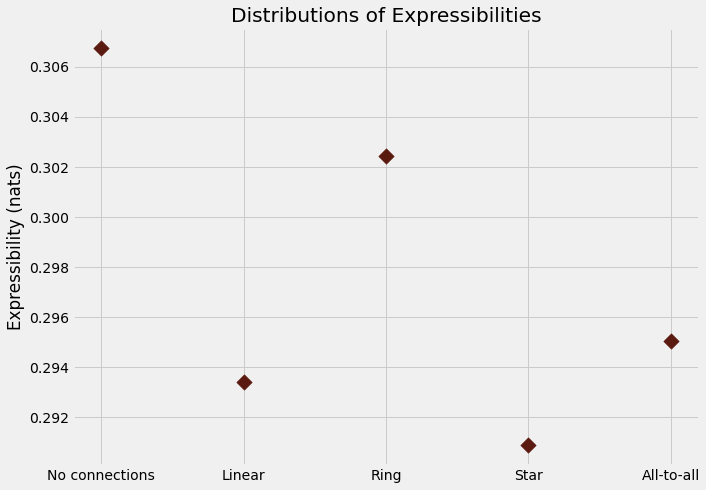

In [30]:
#Colors inspiration: https://i.natgeofe.com/n/d01e30a9-0e4d-4fe7-ae8a-5dca3aa6e8c2/72840.jpg


# expressibilities
express = [D_KL_noconnec, D_KL_linear, D_KL_ring, D_KL_star, D_KL_alltoall]

# circuits type
circuits = ["No connections", "Linear", "Ring", "Star", "All-to-all"]

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.scatter(circuits, express, s = 120, marker = 'D', color="#5A1A0F")

ax.title.set_text('Distributions of Expressibilities')
ax.set_ylabel('Expressibility (nats)')